In [2]:
# İmports 

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# İmports for graph display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Defining Data and functions (AChE Activity Sample)

data = {
    'SMILES': [
        'Cc1ccccc1N(C)C(=O)OC',           # Active
        'COC(=O)c1cncc(OC)c1',           # Active
        'CCC(C)C(=O)O',                   # Inactive
        'O=C(O)c1ccccc1C(=O)O',           # Moderately Active
        'C1CCN(CC1)Cc1ccc(OC)cc1'        # Highly Active
    ],
    'Activity_pIC50': [7.0, 7.5, 4.5, 6.2, 8.1] 
}
df_new = pd.DataFrame(data)

In [4]:
# RDKit Functions

def smiles_to_mol(smiles):
    return Chem.MolFromSmiles(smiles) 

def calculate_morgan_fp(mol, radius=2, nBits=1024):
    if mol is None: 
        return np.zeros(nBits) # Return zero vector for bad SMILES
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return np.array(fp)

# Labeling Function (Determines the final 'y' class)

TRESHOLD = 6.5
df_new['Activity_Class'] = np.where(df_new['Activity_pIC50'] > TRESHOLD, 1, 0)

In [5]:
# Featurization 

df_new['Mol_Object'] = df_new['SMILES'].apply(smiles_to_mol)
df_new['Morgan_FP'] = df_new['Mol_Object'].apply(calculate_morgan_fp)
# Creating Matrix for ML

# X: Feature Matrix (1024-bit fingerprints)
X = np.stack(df_new['Morgan_FP'].values)
# y: Target Vector (Active = 1, Inactive = 0)
y = df_new['Activity_Class'].values

print(" Data Preparation Status ")
print(f"Total Samples (X): {X.shape[0]} | Target Labels (y): {y}")

 Data Preparation Status 
Total Samples (X): 5 | Target Labels (y): [1 1 0 0 1]


[21:02:30] DEPRECATION WARNING: please use MorganGenerator
[21:02:30] DEPRECATION WARNING: please use MorganGenerator
[21:02:30] DEPRECATION WARNING: please use MorganGenerator
[21:02:30] DEPRECATION WARNING: please use MorganGenerator
[21:02:30] DEPRECATION WARNING: please use MorganGenerator


In [7]:
# Model Training and Validation (using the safest method for small data)

print("\n Starting Model Training (Random Forest) ")

# Assuming X and y are now defined from previous cells:
from sklearn.model_selection import train_test_split 
# Note: You can skip the split and fit on all data for feature importance if you prefer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Define the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# CRITICAL: Fit the model explicitly
rf_model.fit(X_train, y_train)

# Apply 2-Fold Cross-Validation (cv=2 is used because the smallest class has 2 members)
cv_scores = cross_val_score(rf_model, X, y, cv=2, scoring='accuracy')

# Calculate the final average score
average_accuracy = cv_scores.mean()

print("\n Final Model Validation ")
print(f"Individual CV Scores (2 Folds): {cv_scores}")
print(f"Random Forest Average Cross-Validation Score: {average_accuracy * 100:.2f}%")

#QSAR Pipeline Completed!


 Starting Model Training (Random Forest) 

 Final Model Validation 
Individual CV Scores (2 Folds): [0.33333333 0.5       ]
Random Forest Average Cross-Validation Score: 41.67%


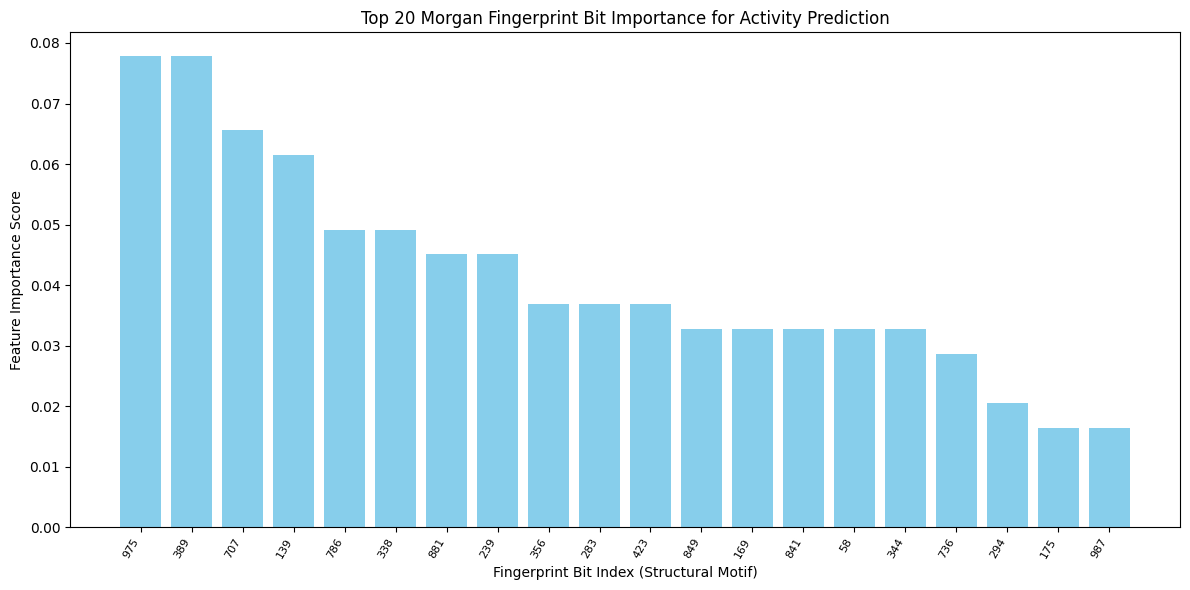

In [8]:
# Codes for graph display
# Feature importances from the trained model
importances = rf_model.feature_importances_

# İndices (0 to 1023)
feature_indices = np.arange(X.shape[1]) 

# Features sorted by importance (descending)
sorted_indices = np.argsort(importances)[::-1] 

# Only the top 20 most important bits displayed as coloumns
top_20_indices = sorted_indices[:20]
top_20_importances = importances[top_20_indices]

# For the Results
plt.figure(figsize=(12, 6))
plt.bar(range(20), top_20_importances, color='skyblue')
plt.xticks(range(20), top_20_indices, rotation=60, ha='right', fontsize=8) 
plt.title("Top 20 Morgan Fingerprint Bit Importance for Activity Prediction")
plt.xlabel("Fingerprint Bit Index (Structural Motif)")
plt.ylabel("Feature Importance Score")
plt.tight_layout()
plt.show()